# Langevin Monte Carlo | Unadjusted Langevin Algorithm

A way to sample from a target distribution that requires $\nabla_X \log p(X)$ to be available. The Langevin dynamics drive the random walk towards regions of high probability using gradient flow. The method constructs a Markov chain $q(X_t|X_{t-1}=x_{t-1}) \sim \mathcal{N}(X_t;\mu=x_{t-1} + \tau \nabla_X \log p(X)\vert_{x_{t-1}}, \sigma^2=2\tau)$

This is related to generative models that use the gradient of the data distribution.

References
- https://en.wikipedia.org/wiki/Metropolis-adjusted_Langevin_algorithm
- https://yang-song.github.io/blog/2021/score/


In [ ]:
import torch
import torch.distributions as D
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
from typing import Iterator, Callable
import itertools
import time

In [1]:
! pip install git+https://github.com/cheind/diffusion-models.git

  Cloning https://github.com/cheind/diffusion-models.git to /tmp/pip-req-build-s5sgfvhn
  Running command git clone -q https://github.com/cheind/diffusion-models.git /tmp/pip-req-build-s5sgfvhn
  Created wheel for diffusion-models: filename=diffusion_models-1.0.0-py3-none-any.whl size=2844 sha256=55591caa4c15b4e159e13e9dd560f8a659c6ee035284940c861473c1858fe145
  Stored in directory: /tmp/pip-ephem-wheel-cache-6vp84nj2/wheels/21/ec/80/bc93fe5a389e52a1b0cdc3ee4cc3511c5c6cc8f3a6393b1b93
Successfully built diffusion-models


In [ ]:
def iterate_langevin(grad_logp_fn: Callable[[torch.Tensor],torch.Tensor], x0:torch.Tensor, tau:float, burnin:int=1000) -> Iterator[torch.Tensor]:
  x = x0.requires_grad_(True)  
  tau = torch.as_tensor(tau)
  sqrt_2tau = torch.sqrt(2*tau)  

  for i in itertools.count(0):
    if i > burnin:
      yield x.detach()
    eps = torch.empty_like(x0).normal_(mean=0., std=1.)    
    x = x + tau * grad_logp_fn(x) + sqrt_2tau*eps

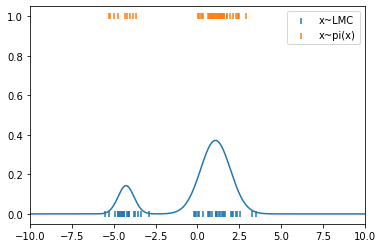

In [ ]:
torch.manual_seed(222)

mix = D.Categorical(F.softmax(torch.randn(2,)))
comp = D.Normal(torch.randn(2,)*2, torch.rand(2,))
pi = D.MixtureSameFamily(mix, comp)

xpdf = torch.linspace(-10, 10, 500)
ypdf = torch.exp(pi.log_prob(xpdf))

x0 = torch.rand(50)*20 - 10

def grad_logp_fn(x:torch.Tensor)->torch.Tensor:
  grads = torch.autograd.grad(pi.log_prob(x).sum(), x)
  return grads[0]

g = iterate_langevin(grad_logp_fn, x0, tau=1e-2, burnin=100)

for x in itertools.islice(g, 100):
  plt.xlim(-10, 10)
  plt.scatter(x, torch.zeros_like(x), marker='|', linewidths=0.5, label='x~LMC')
  plt.scatter(pi.sample((50,)), torch.ones(50), marker='|', linewidths=0.5, label='x~pi(x)')
  plt.plot(xpdf, ypdf)
  plt.legend(loc='upper right')
  plt.show()  
  time.sleep(0.02)
  clear_output(wait=True)

## Observations
 - if the x is in regions where the $\nabla_x \log p(x)$ is small, nearly no deterministic movement happens. Only the random term would then push x around
 - if your distribution happens to have multiple modalities with valleys of zero score function gradients in between and all your points starts in one mode, chances are slim that you will populate the other modes.
 - If $\tau$ is small, we introduce only small bias but it takes a large number of iterations to explore the support of the target distribution. If $\tau$ is large quickly the support of the target distribution but introduce more bias. Should we start we change $\tau$ over time?

https://github.com/abdulfatir/sampling-methods-numpy/blob/master/Langevin-Monte-Carlo.ipynb

## Sampling from energy models
Consider a density of following form $$p(x)=\frac{1}{Z}q(x),$$ where $Z$ is the partition function given by $\int_r q(r)dr$. Often the partition function is intractable. However, for sampling we don't require it
$$
\begin{align}
\nabla_x \log p(x) &= \nabla_x\log q(x) - \nabla_x \log Z \\
& = \nabla_x\log q(x),
\end{align}
$$ 
since $Z$ does not depend on $x$ (integrated out). Hence, for the purpose of sampling, $Z$ is not required. The example below samples from an energy-model $$p(x)=\frac{1}{Z}e^{-U(x)}.$$ From above we have $\nabla_x \log p(x) = -\nabla_x U(x)$.

(50000, 2)


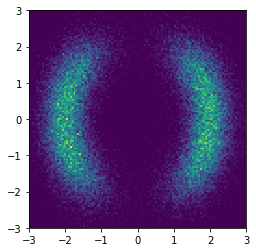

In [ ]:
def u(z):
    # Taken from https://github.com/abdulfatir/sampling-methods-numpy/blob/master/Langevin-Monte-Carlo.ipynb
    z = z.view(-1, 2)
    z1, z2 = z[:, 0], z[:, 1]
    norm = torch.norm(z, p=2, dim=1)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return u


def grad_logp(x:torch.Tensor)->torch.Tensor:
  grads = torch.autograd.grad(-u(x).sum(), x)
  return grads[0]

# Multiple samples, after iteration 1001
x0 = torch.randn(50000,2)
g = iterate_langevin(grad_logp, x0, tau=1e-2, burnin=1000)
samples = torch.cat(list(itertools.islice(g, 1)), 0).numpy()
print(samples.shape)

plt.hist2d(samples[:,0], samples[:,1], cmap='viridis', rasterized=False, bins=128)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

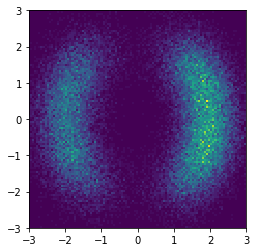

In [ ]:
# Same as above, but just one sample bouncing around. Slightly higher tau to allow
# easier transitions between modes
x0 = torch.randn(1,2)
g = iterate_langevin(grad_logp, x0, tau=1e-1, burnin=1000)
samples = torch.cat(list(itertools.islice(g, 50000)), 0).numpy()
plt.hist2d(samples[:,0], samples[:,1], cmap='viridis', rasterized=False, bins=128)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

In [ ]:
from functools import partial
def f(x,y):
  return (2*x**2*y).sum()

x = torch.tensor([1.,2.,3.])
y = torch.tensor([4.,5.,6.])
x.requires_grad_()
y.requires_grad_()
g = torch.autograd.grad(f(x,y), x, create_graph=True)[0]
h = torch.empty(3)
for i in range(len(g)):
  # The following line is equivalent to
  # mask = torch.zeros_like(g)
  # mask[i][j] = 1
  # torch.autograd.grad(g, inp, grad_output=mask, retain_graph=True, create_graph=True)[0]
  
  dgdx = torch.autograd.grad(g[i], x, retain_graph=True, create_graph=True)[0]
  h[i] = dgdx[i]
del x.grad
# x.grad = None
# x.requires_grad_(False)

torch.pow((h-g),2).sum().backward()
print(h, g, y.grad)


tensor([16., 20., 24.], grad_fn=<CopySlices>) tensor([16., 40., 72.], grad_fn=<MulBackward0>) tensor([  0., 160., 768.])
